## COSC2999:Pratical Data Science
## Assignment 3: Group Project
### Group 6:
Vu Quoc Gia Quan - s3927120  
William TRAN - s4196432  
Sébastien MASSY - s4196435

### Project Goal:
- Develop and compare at least 2 models to predict Revenue attribute in Online Shoppers Purchasing Intention Dataset from (UCI Machine Learning Repository, n.d.)
- Implement at least 2 clustering algorithm for the dataset
- Enhance model performance by adding cluster labels as additional features and evaluate their impact on model accuracy

## Task 1: Retrieving and Preparing the Data

In [1]:
import pandas as pd
import numpy as np
import random

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [2]:
# Load and make a deep copy of the dataset
df_raw = pd.read_csv("online_shoppers_intention.csv")
df = df_raw.copy(deep=True) 

In [3]:
# Quick overview
print("Shape :", df.shape)
print("Types : ", df.dtypes)
display(df.head(3))


Shape : (12330, 18)
Types :  Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


In [4]:
# Remove leading and trailing white spaces from columns' name
df.columns = df.columns.str.strip()

All columns name look normal through observation.

In [5]:
# SIMPLE STRUCTURAL CHECKS
# missing values
missing = df.isna().sum()
print("\nMissing values (non-zero only):")
print(missing[missing > 0])

# 3.3 duplicates
dup_count = df.duplicated().sum()
print("\nExact duplicate rows:", dup_count)



Missing values (non-zero only):
Series([], dtype: int64)

Exact duplicate rows: 125


We checked for missing value and found none in the dataset but there were 125 duplicates entries.

In [6]:
# drop duplicates
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(f"Removed {before-after} duplicate rows. New shape: {df.shape}")


Removed 125 duplicate rows. New shape: (12205, 18)


These duplicates were removed and the data shape changed change from (12330,18) to (12205,18).

In [7]:
# drop sessions with logical inconsistencies (visits > 0 but duration = 0)
mask_inconsistent = (
    ((df['Administrative'] > 0) & (df['Administrative_Duration'] == 0)) |
    ((df['Informational'] > 0) & (df['Informational_Duration'] == 0)) |
    ((df['ProductRelated'] > 0) & (df['ProductRelated_Duration'] == 0))
)
df = df[~mask_inconsistent]

print(f"Rows remaining after cleaning: {df.shape[0]}")

Rows remaining after cleaning: 11261


In [8]:
# Check some basic info about datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11261 entries, 1 to 12204
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           11261 non-null  int64  
 1   Administrative_Duration  11261 non-null  float64
 2   Informational            11261 non-null  int64  
 3   Informational_Duration   11261 non-null  float64
 4   ProductRelated           11261 non-null  int64  
 5   ProductRelated_Duration  11261 non-null  float64
 6   BounceRates              11261 non-null  float64
 7   ExitRates                11261 non-null  float64
 8   PageValues               11261 non-null  float64
 9   SpecialDay               11261 non-null  float64
 10  Month                    11261 non-null  object 
 11  OperatingSystems         11261 non-null  int64  
 12  Browser                  11261 non-null  int64  
 13  Region                   11261 non-null  int64  
 14  TrafficType              11

We can observe that most data are in integer and float datatype while "Month" and "VisitorType" are object datatype. We also see that "Weekend" and "Revenue" are in boolean datatype. These will be addressed during feature engineering.

In [9]:
# Check for unique values in attributes with object datatype
for c in df.select_dtypes(include="object"):
    df[c] = df[c].str.strip().str.lower()
    print(f"Unique values in '{c}': {df[c].unique()}")

Unique values in 'Month': ['feb' 'mar' 'may' 'oct' 'june' 'jul' 'aug' 'nov' 'sep' 'dec']
Unique values in 'VisitorType': ['returning_visitor' 'new_visitor' 'other']


In [10]:
# Check for empty string in dataset
(df == "").any(axis=1).sum()

np.int64(0)

After checking for empty strings, we confirmed that the data have no such entries.

In [11]:
# Use descriptive statistic to check for abnormalities
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.00000,11261.000000,11261.000000,11261.000000
mean,2.456798,86.191390,0.524909,37.512203,33.446763,1262.600455,0.011446,0.033255,6.278312,0.061451,2.12228,2.359737,3.154693,4.034278
std,3.383224,181.479770,1.316593,146.748451,45.173596,1953.695118,0.022044,0.030207,19.209424,0.199261,0.89247,1.706369,2.399795,3.966364
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,237.333333,0.000000,0.013333,0.000000,0.000000,2.00000,2.000000,1.000000,2.000000
50%,1.000000,16.666667,0.000000,0.000000,19.000000,659.636111,0.001754,0.023902,0.000000,0.000000,2.00000,2.000000,3.000000,2.000000
75%,4.000000,101.000000,0.000000,0.000000,39.000000,1543.423333,0.013333,0.041810,0.000000,0.000000,3.00000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.00000,13.000000,9.000000,20.000000


In [12]:
# Define continuous attribute
continuous_cols = ["Administrative", 
                   "Administrative_Duration", 
                   "Informational", 
                   "Informational_Duration", 
                   "ProductRelated", 
                   "ProductRelated_Duration", 
                   "BounceRates", 
                   "ExitRates", 
                   "PageValues", 
                   "SpecialDay"]

In [13]:
# Define categorical attribute
categorical_cols = ["Month", 
                    "OperatingSystems",
                    "VisitorType",
                    "Browser",
                    "Region",
                    "TrafficType",
                    "Weekend",
                    "Revenue"]

In [14]:
# Calculate Q1, Q3, and IQR for all continuous columns
Q1 = df[continuous_cols].quantile(0.25)
Q3 = df[continuous_cols].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Create a DataFrame showing whether each value is an outlier (True/False)
outlier_flags = (df[continuous_cols] < lower) | (df[continuous_cols] > upper)

# Optionally, count how many outliers per column
outlier_counts = outlier_flags.sum()

print("Outlier counts per column:\n", outlier_counts)

# If you want to see the actual rows with any outliers:
outlier_rows = df[outlier_flags.any(axis=1)]


Outlier counts per column:
 Administrative              391
Administrative_Duration    1002
Informational              2373
Informational_Duration     2373
ProductRelated              953
ProductRelated_Duration     876
BounceRates                1176
ExitRates                   847
PageValues                 2633
SpecialDay                 1140
dtype: int64


Text(0.5, 1.0, 'Box plots of continuous features')

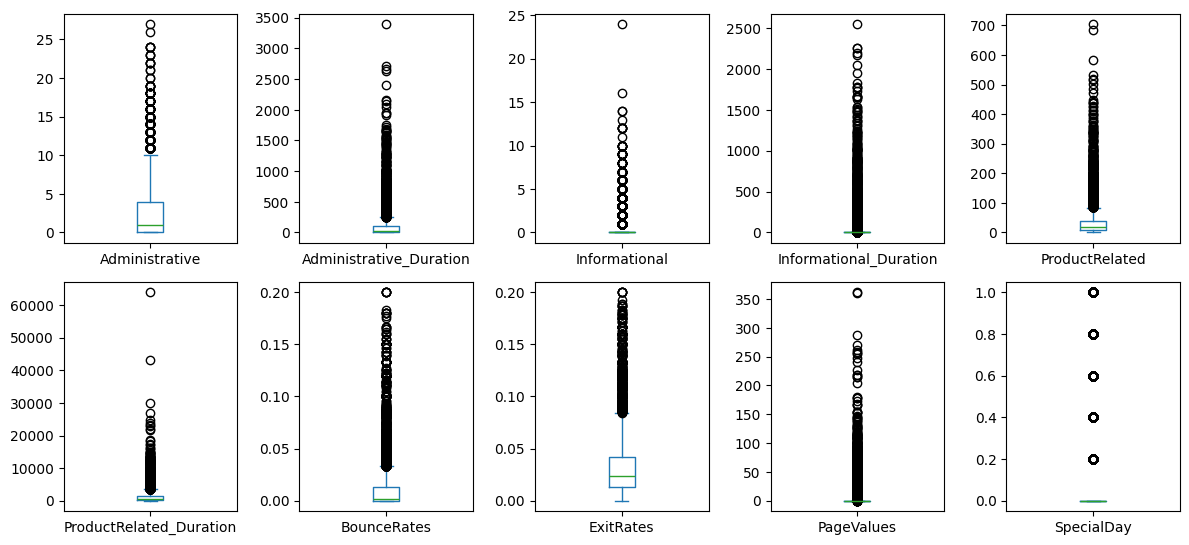

In [15]:
import matplotlib.pyplot as plt

df[continuous_cols].plot(kind="box", subplots=True, layout=(3,5), figsize=(12,8))
plt.tight_layout()
plt.title("Box plots of continuous features")

There were a lot of outliers in continuous attribute which could skew our model's performance. These will be dealt with during feature engineering.

## <u>Task 2 — Feature Engineering (transformations + feature selection)</u>
We now define consistent preprocessing for **classification** and **clustering** using sklearn Pipelines.

Principles:
- Keep preprocessing inside a Pipeline/ColumnTransformer to ensure consistency across splits.
- Perform feature selection based on training data only.


### __2.1 - Train / Validation / Test split__
The dataset was split into training (70%), validation (15%), and test (15%) sets using stratified sampling to maintain the class distribution of the target variable. This will ensured unbiased model evaluation and prevented information leakage during feature engineering and model selection.

In [16]:
from sklearn.model_selection import train_test_split

TARGET = "Revenue"

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


Train: (7882, 17)
Val:   (1689, 17)
Test:  (1690, 17)


### __2.2 - Feature grouping__
Different features need different transformations. Treating everything the same hurts performance and interpretability.

In [17]:
# Count features (zero-inflated, integer)
count_features = [
    "Administrative", "Informational", "ProductRelated"
]

# Duration & value features (heavy-tailed)
duration_features = [
    "Administrative_Duration", "Informational_Duration",
    "ProductRelated_Duration", "PageValues"
]

# Rate / bounded features
rate_features = [
    "BounceRates", "ExitRates", "SpecialDay"
]

# Encoded categoricals (already numeric labels, NOT ordinal)
encoded_cat_features = [
    "OperatingSystems", "Browser", "Region", "TrafficType"
]

# True categoricals
categorical_features = [
    "Month", "VisitorType"
]

# Binary
binary_features = ["Weekend"]


### __2.3 - Feature transformation choices / Preprocessing pipelines__

#### 2.3.1 Log-transform heavy-tailed features

Durations and PageValues have extreme outliers. Log transform:
- stabilizes variance
- reduces dominance of extreme values
- helps linear & distance-based models

We use log1p to handle zeros safely.

#### 2.3.2 Scaling

Required for clustering (distance-based)

Optional but helpful for classification models

We use StandardScaler.

#### 2.3.3 Encoding categoricals

Month, VisitorType → OneHotEncoder

Encoded numeric categories (Browser, Region, etc.) → treat as categorical. These can be kept as categorical as to not over inflate the dataset

Why not leave them numeric?
Their numeric labels have no order meaning. Leaving them numeric introduces fake ordinal relationships.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
import numpy as np

log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

numeric_pipeline = Pipeline(steps=[
    ("log", log_transformer),
    ("scaler", StandardScaler())
])

rate_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess_classification = ColumnTransformer(
    transformers=[
        ("counts", numeric_pipeline, count_features),
        ("durations", numeric_pipeline, duration_features),
        ("rates", rate_pipeline, rate_features),
        ("encoded_cat", "passthrough", encoded_cat_features),
        ("categorical", categorical_pipeline, categorical_features),
        ("binary", "passthrough", binary_features),
    ],
    remainder="drop"
)

### __2.4 - Clustering preprocessing pipeline__

Differences from classification:

- No target
- Scaling is mandatory
- Same transformations → consistency

In [19]:
preprocess_clustering = ColumnTransformer(
    transformers=[
        ("counts", numeric_pipeline, count_features),
        ("durations", numeric_pipeline, duration_features),
        ("rates", rate_pipeline, rate_features),
        ("encoded_cat", "passthrough", encoded_cat_features),
        ("categorical", categorical_pipeline, categorical_features),
        ("binary", "passthrough", binary_features),
    ],
    remainder="drop"
)

#### __2.5 - Correlation with target (classification)__

What we are looking for:

- PageValues (log) → strong positive correlation
- Duration-related features → moderate
- BounceRates / ExitRates → negative

In [20]:
X_train_processed = preprocess_classification.fit_transform(X_train)
feature_names = preprocess_classification.get_feature_names_out()

X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

# Reset index of y_train to match X_train_df (which has a default RangeIndex)
y_train_reset = y_train.reset_index(drop=True)

# Calculate correlation with the aligned target
corr_with_target = X_train_df.corrwith(y_train_reset).sort_values(key=np.abs, ascending=False)

display(corr_with_target.head(10))

X_val_processed = preprocess_classification.transform(X_val)
X_val_df = pd.DataFrame(X_val_processed, columns=feature_names)

durations__PageValues                 0.639520
rates__ExitRates                     -0.208114
durations__ProductRelated_Duration    0.181233
counts__ProductRelated                0.169789
categorical__Month_nov                0.150577
durations__Administrative_Duration    0.149709
counts__Administrative                0.145238
rates__BounceRates                   -0.132119
durations__Informational_Duration     0.114467
counts__Informational                 0.107246
dtype: float64

### __2.6 - Redundancy check__


In [21]:
corr_matrix = X_train_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [
    (col, upper[col].idxmax(), upper[col].max())
    for col in upper.columns if upper[col].max() > 0.9
]

high_corr_pairs[:10]


[('durations__Administrative_Duration',
  'counts__Administrative',
  np.float64(0.9240795854257844)),
 ('durations__Informational_Duration',
  'counts__Informational',
  np.float64(0.9361640374016478)),
 ('categorical__VisitorType_returning_visitor',
  'categorical__VisitorType_new_visitor',
  np.float64(0.9767595770049923))]

__Decision rationale:__
- No features removed yet
- Strong predictors retained (PageValues, durations)
- Redundancy will be handled by:
- regularization (classification)
- PCA / clustering robustness (later)

In Task 2, feature engineering was performed using sklearn pipelines to ensure consistent transformations across training, validation, and test sets. Features were grouped by semantic type and transformed accordingly. Heavy-tailed duration and value variables were log-transformed, categorical variables were one-hot encoded, and all numeric features were scaled. Feature relevance was evaluated using correlation analysis on the training set only, confirming PageValues and session duration variables as strong predictors of purchase intent. No features were removed at this stage to preserve information for downstream models.

In [22]:
df["Revenue"].value_counts()

Revenue
False    9441
True     1820
Name: count, dtype: int64

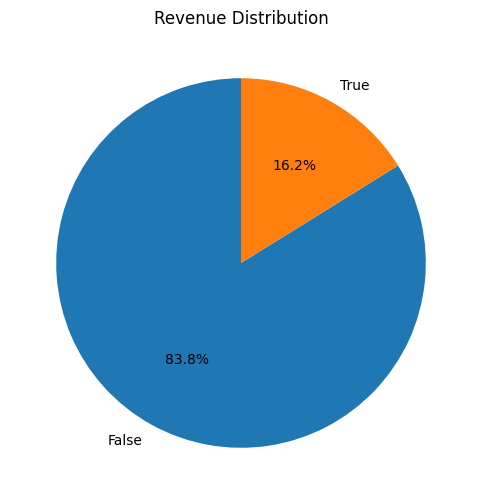

In [23]:
# 1. Pie Chart
gender_counts = df['Revenue'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Revenue Distribution')
plt.show()


In [24]:
# Check Revenue distribution (imbalance)
print("Revenue distribution before balancing:")
print(df["Revenue"].value_counts())
print("\nPercentage distribution:")
print(df["Revenue"].value_counts(normalize=True) * 100)

Revenue distribution before balancing:
Revenue
False    9441
True     1820
Name: count, dtype: int64

Percentage distribution:
Revenue
False    83.838025
True     16.161975
Name: proportion, dtype: float64


There is a high imbalance within Revenue with True being only 15.6% and False being 84.4%

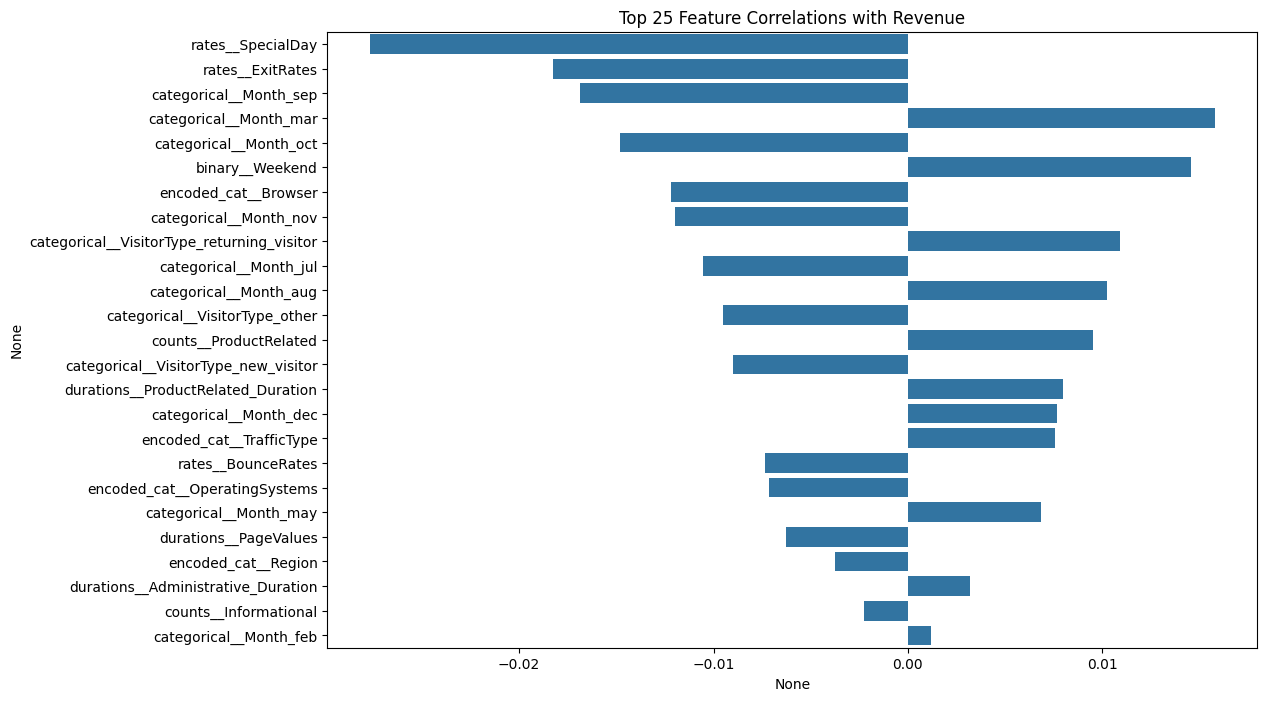

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the correlation matrix
corr_with_target = X_train_df.corrwith(y_train).sort_values(key=np.abs, ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x=corr_with_target.head(25), y=corr_with_target.head(25).index)
plt.title("Top 25 Feature Correlations with Revenue")
plt.show()

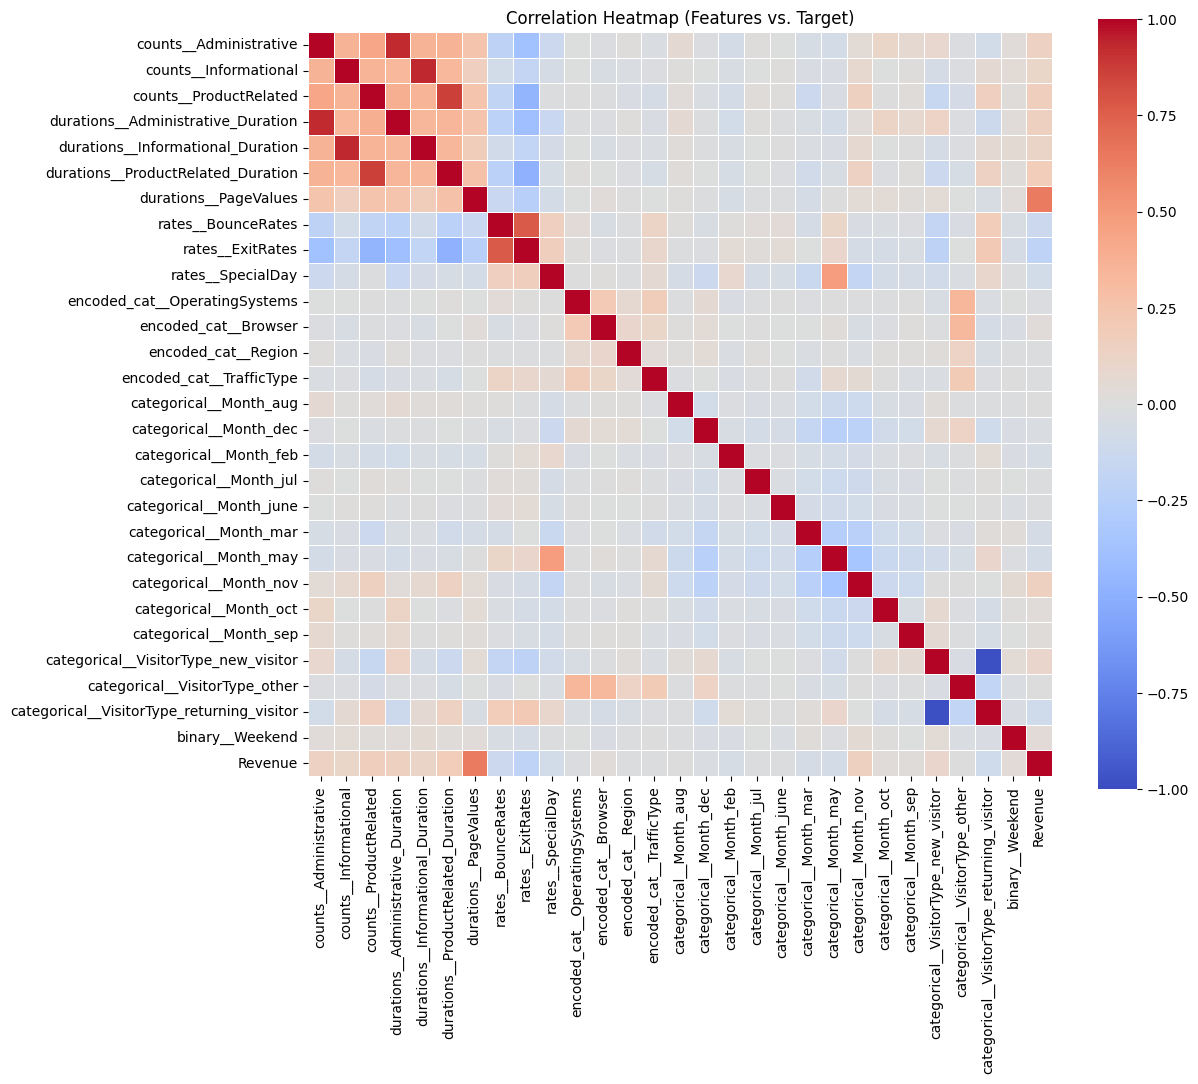

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create a temporary dataframe that includes both Features AND Target
# We align them by index to ensure rows match correctly
df_for_heatmap = X_train_df.copy()
df_for_heatmap['Revenue'] = y_train.values

# 2. Compute the correlation matrix including the target
corr = df_for_heatmap.corr()

# 3. Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr, 
            annot=False, 
            cmap='coolwarm', 
            vmin=-1, vmax=1, 
            square=True, 
            linewidths=.5)

plt.title("Correlation Heatmap (Features vs. Target)")
plt.show()

We decided to use recursive feature elimination with cross validation to select the best feature after preprocessing.(GeeksforGeeks, 2025c)  


In [27]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import pandas as pd

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Logistic Regression RFECV
rfecv_lr = RFECV(
    estimator=LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    step=1,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

# Apply RFECV
X_train_selected_lr = rfecv_lr.fit_transform(X_train_df, y_train)
X_val_selected_lr = rfecv_lr.transform(X_val_df)

# Get selected feature names
selected_columns_lr = X_train_df.columns[rfecv_lr.support_]

print("Logistic Regression RFECV")
print("Original shape:", X_train_df.shape)
print("Reduced shape:", X_train_selected_lr.shape)
print("Optimal number of features selected:", rfecv_lr.n_features_)
print("Selected features:", list(selected_columns_lr))

# Random Forest RFECV
rfecv_rf = RFECV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=200, max_depth=20),
    step=1,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

# Apply RFECV 
X_train_selected_rf = rfecv_rf.fit_transform(X_train_df, y_train)
X_val_selected_rf = rfecv_rf.transform(X_val_df)

# Get selected feature names
selected_columns_rf = X_train_df.columns[rfecv_rf.support_]

print("\nRandom Forest RFECV")
print("Original shape:", X_train_df.shape)
print("Reduced shape:", X_train_selected_rf.shape)
print("Optimal number of features selected:", rfecv_rf.n_features_)
print("Selected features:", list(selected_columns_rf))

# Union of features
union_features = list(set(selected_columns_lr).union(set(selected_columns_rf)))
X_train_union = X_train_df[union_features].copy()
X_val_union = X_val_df[union_features].copy()

print("\nUnion of selected features")
print("Total features in union:", len(union_features))
print("Union features:", union_features)


Logistic Regression RFECV
Original shape: (7882, 28)
Reduced shape: (7882, 19)
Optimal number of features selected: 19
Selected features: ['counts__Administrative', 'counts__ProductRelated', 'durations__Informational_Duration', 'durations__PageValues', 'rates__BounceRates', 'rates__ExitRates', 'encoded_cat__OperatingSystems', 'categorical__Month_aug', 'categorical__Month_dec', 'categorical__Month_feb', 'categorical__Month_jul', 'categorical__Month_june', 'categorical__Month_mar', 'categorical__Month_may', 'categorical__Month_nov', 'categorical__Month_sep', 'categorical__VisitorType_other', 'categorical__VisitorType_returning_visitor', 'binary__Weekend']

Random Forest RFECV
Original shape: (7882, 28)
Reduced shape: (7882, 13)
Optimal number of features selected: 13
Selected features: ['counts__Administrative', 'counts__ProductRelated', 'durations__Administrative_Duration', 'durations__Informational_Duration', 'durations__ProductRelated_Duration', 'durations__PageValues', 'rates__Bounce

In [28]:
X_train_union.head()

,durations__Administrative_Duration,categorical__VisitorType_returning_visitor,binary__Weekend,categorical__VisitorType_other,encoded_cat__Browser,categorical__Month_aug,categorical__Month_may,counts__Administrative,encoded_cat__OperatingSystems,encoded_cat__TrafficType,...,categorical__Month_jul,categorical__Month_mar,categorical__Month_june,encoded_cat__Region,durations__PageValues,categorical__Month_feb,counts__ProductRelated,rates__ExitRates,categorical__Month_dec,categorical__Month_nov
0,0.714712,0.0,0.0,0.0,2.0,0.0,0.0,0.623857,2.0,5.0,...,0.0,0.0,0.0,1.0,-0.512599,0.0,-0.596178,-0.546726,0.0,0.0
1,-1.045022,1.0,0.0,0.0,8.0,0.0,0.0,-0.968736,1.0,1.0,...,1.0,0.0,0.0,1.0,-0.512599,0.0,-0.230373,-0.032577,0.0,0.0
2,1.452709,1.0,0.0,0.0,1.0,0.0,0.0,1.089660,1.0,2.0,...,0.0,0.0,0.0,1.0,-0.512599,0.0,-0.293381,-0.053839,0.0,0.0
3,0.725080,1.0,0.0,0.0,5.0,0.0,1.0,1.089660,2.0,3.0,...,0.0,0.0,0.0,7.0,-0.512599,0.0,0.862309,-0.891023,0.0,0.0
4,-1.045022,1.0,0.0,0.0,2.0,0.0,1.0,-0.968736,2.0,2.0,...,0.0,0.0,0.0,9.0,-0.512599,0.0,-1.037442,-0.877251,0.0,0.0


In [29]:
X_train_union.columns

Index(['durations__Administrative_Duration',
       'categorical__VisitorType_returning_visitor', 'binary__Weekend',
       'categorical__VisitorType_other', 'encoded_cat__Browser',
       'categorical__Month_aug', 'categorical__Month_may',
       'counts__Administrative', 'encoded_cat__OperatingSystems',
       'encoded_cat__TrafficType', 'durations__ProductRelated_Duration',
       'categorical__Month_sep', 'durations__Informational_Duration',
       'rates__BounceRates', 'categorical__Month_jul',
       'categorical__Month_mar', 'categorical__Month_june',
       'encoded_cat__Region', 'durations__PageValues',
       'categorical__Month_feb', 'counts__ProductRelated', 'rates__ExitRates',
       'categorical__Month_dec', 'categorical__Month_nov'],
      dtype='object')

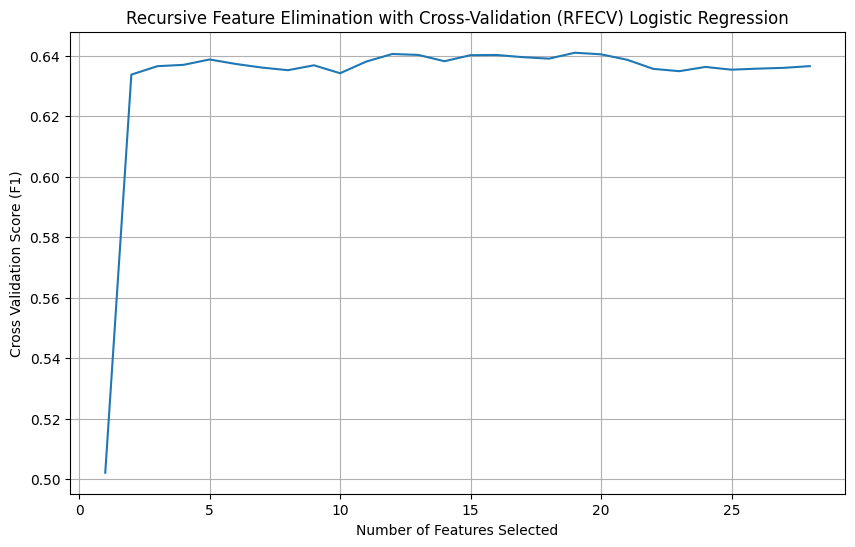

Optimal number of features: 19


In [30]:
import matplotlib.pyplot as plt

# Plotting the RFECV results
plt.figure(figsize=(10, 6))
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross Validation Score (F1)")

# The 'cv_results_' attribute contains the scores for each number of features
# We plot the mean test score across the cross-validation folds
plt.plot(range(1, len(rfecv_lr.cv_results_['mean_test_score']) + 1), 
         rfecv_lr.cv_results_['mean_test_score'])

plt.title("Recursive Feature Elimination with Cross-Validation (RFECV) Logistic Regression")
plt.grid()
plt.show()

print("Optimal number of features: %d" % rfecv_lr.n_features_)

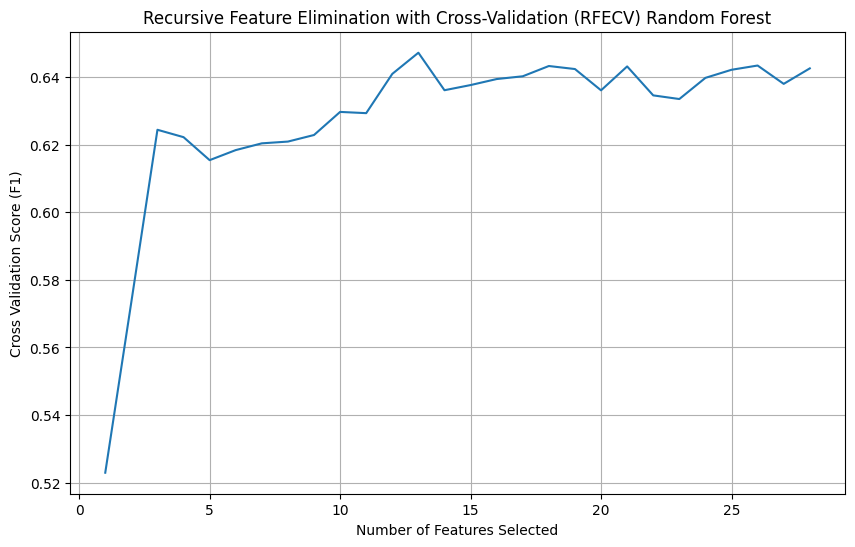

Optimal number of features: 13


In [31]:
import matplotlib.pyplot as plt

# Plotting the RFECV results
plt.figure(figsize=(10, 6))
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross Validation Score (F1)")

# The 'cv_results_' attribute contains the scores for each number of features
# We plot the mean test score across the cross-validation folds
plt.plot(range(1, len(rfecv_rf.cv_results_['mean_test_score']) + 1), 
         rfecv_rf.cv_results_['mean_test_score'])

plt.title("Recursive Feature Elimination with Cross-Validation (RFECV) Random Forest")
plt.grid()
plt.show()

print("Optimal number of features: %d" % rfecv_rf.n_features_)

We will be reusing some old functions from our teammate previous assignment to train and save models as well as visualize performance

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Build a model to train and save model
def train_and_save(model, X_train, y_train, X_test, y_test, model_name, results_dict):
    model.fit(X_train, y_train)

    print('Model accuracy for train set: {0:.3f}'.format(model.score(X_train, y_train)))
    print('Model accuracy for test set: {0:.3f}'.format(model.score(X_test, y_test)))
    
    y_pred = model.predict(X_test)

    # Classification Report
    print('\n{}'.format(classification_report(y_test, y_pred)))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', cm)

    # Accuracy Score
    auc = accuracy_score(y_test, y_pred)
    print('\nAccuracy Score: ', round(auc,3))
    
    # Collect metrics
    results_dict[model_name] = {
        'Train Accuracy': model.score(X_train, y_train),
        'Test Accuracy': model.score(X_test, y_test),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted')
    }
    
    return model, results_dict

In [33]:
# Build a function to train and save functions afer running GridSearchCV
def train_and_save_hyper(model, X_train, y_train, X_test, y_test, model_name, results_dict):
    model.fit(X_train, y_train)

    print('Model accuracy for train set: {0:.3f}'.format(model.score(X_train, y_train)))
    print('Model accuracy for test set: {0:.3f}'.format(model.score(X_test, y_test)))

    print("Best parameters found: ", model.best_params_)
    print("Best cross-validation score: ", model.best_score_)
    
    y_pred = model.predict(X_test)

    # Classification Report
    print('\n{}'.format(classification_report(y_test, y_pred)))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', cm)

    # Accuracy Score
    auc = accuracy_score(y_test, y_pred)
    print('\nAccuracy Score: ', round(auc,3))
    
    # Collect metrics
    results_dict[model_name] = {
        'Train Accuracy': model.score(X_train, y_train),
        'Test Accuracy': model.score(X_test, y_test),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted')
    }
    
    return model, results_dict

In [34]:
# Function to plot classification results
def plot_classification_results(results_df):
    plt.figure(figsize=(20, 10))
    ax = results_df[['Accuracy', 'Precision', 'Recall', 'F1']].plot(kind='bar', figsize=(20, 10))
    plt.title('Classification Model Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
     # Add value labels 
    for p in ax.patches: 
        height = p.get_height() 
        percent = height * 100
        ax.annotate(f'{percent:.1f}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom', fontsize=9)
    plt.show()

## Task 3: Data Modeling

### Classification task:

To address the significant class imbalance in Revenue, we applies Synthetic Minority Oversampling Technique (SMOTE) to the training data which generate synthetic samples of minority class.(Cory Maklin, n.d.)  

In [35]:
# Using SMOTE to fix class imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)

X_train_smote, y_train_smote = smote.fit_resample(X_train_union, y_train)
results_class = {}

We chose four models. The first is Logistic Regression as a baseline due to its simplicity and interpretability. The second is Random Forest Classifier as an intermediate model with enhanced performance through ensemble learning. Finally, we implemented a hybrid ensemble that integrate Random Forest and Logistic Regression to increase performance by combining their strength.

We optimized the models by using GridSearchCV which perform search over predefined parameters grid. The parameters range were selected from official Sci-kit learn library documentation (LogisticRegression, n.d.) (RandomForestClassifier, n.d.). 

Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

# Logistic Regression with hyperparameter tuning
params_log = {
    'C': [0.001, 0.01, 0.1, 1, 5],
    'solver': ['lbfgs'],
    'max_iter': [100,200,500]
}
skf = StratifiedKFold(n_splits = 10, random_state=RANDOM_STATE, shuffle=True)
LR_hyper = GridSearchCV(LR, param_grid = params_log, n_jobs =-1, cv = skf)
model_LogR_hyper, results_class = train_and_save_hyper(LR_hyper, X_train_smote, y_train_smote, X_val_union, y_val, "Logistic Regression Tuned", results_class)

Model accuracy for train set: 0.851
Model accuracy for test set: 0.874
Best parameters found:  {'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}
Best cross-validation score:  0.8512405789864873

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1416
           1       0.58      0.78      0.67       273

    accuracy                           0.87      1689
   macro avg       0.77      0.84      0.79      1689
weighted avg       0.89      0.87      0.88      1689


Confusion Matrix:
 [[1263  153]
 [  60  213]]

Accuracy Score:  0.874


Random Forest

In [37]:
# Random Forest with hyperparameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Parameter are choses based on definition from SKLearn library
params_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [4, 7, 10],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'class_weight': ['balanced']
}

# Hyperparameter tunning using GridSearchCV
skf = StratifiedKFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
RF_hyper = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), param_grid=params_rf, n_jobs=-1, cv=skf)
model_RF_hyper, results_class = train_and_save_hyper(
    RF_hyper, X_train_smote, y_train_smote, X_val_union, y_val, "Random Forest Tuned", results_class
)

d:\project\bs_re\rmit_pds_asm3\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model accuracy for train set: 0.968
Model accuracy for test set: 0.893
Best parameters found:  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score:  0.92985824244916

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1416
           1       0.64      0.78      0.70       273

    accuracy                           0.89      1689
   macro avg       0.80      0.85      0.82      1689
weighted avg       0.90      0.89      0.90      1689


Confusion Matrix:
 [[1295  121]
 [  60  213]]

Accuracy Score:  0.893


Hybrid Ensemble

We are going to weigh Random Forest more since it is the better performing models

In [38]:
from sklearn.ensemble import VotingClassifier
hybrid_model_cluster = VotingClassifier(
    estimators=[('lr', model_LogR_hyper.best_estimator_), ('rf', model_RF_hyper.best_estimator_)],
    voting='soft',
    weights=[1,2]
)

hybrid_model_cluster, results_class = train_and_save(
    hybrid_model_cluster, X_train_smote, y_train_smote, X_val_union, y_val, "Ensemble Model LR-RF", results_class
)

Model accuracy for train set: 0.944
Model accuracy for test set: 0.880

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1416
           1       0.60      0.78      0.68       273

    accuracy                           0.88      1689
   macro avg       0.78      0.84      0.80      1689
weighted avg       0.90      0.88      0.89      1689


Confusion Matrix:
 [[1272  144]
 [  59  214]]

Accuracy Score:  0.88


Next is the clustering task, we decided to use k-means clustering and DBScan.

### Clustering task

We choose KMeans and DBSCAN as our clustering models. Their cluster quality will be judge silhouette coefficients score(GeeksforGeeks, 2025a) to check for how well cluster separation (with values ranging from -1 to 1, where higher values indicate better-defined clusters) and Davies-Bouldin Index(GeeksforGeeks, 2025b) to assess cluster compactness and separation (where lower values indicate better clustering, with 0 being optimal).   

In [39]:
# Rerun the preprocessing using clustering pipeline instead
X_train_processed_cluster = preprocess_clustering.fit_transform(X_train)
feature_names = preprocess_clustering.get_feature_names_out()

# Convert into dataframe
X_train_df_cluster = pd.DataFrame(X_train_processed_cluster, columns=feature_names)
X_val_processed_cluster = preprocess_clustering.transform(X_val)
X_val_df_cluster = pd.DataFrame(X_val_processed_cluster, columns=feature_names)



In [40]:
from sklearn.decomposition import PCA
import pandas as pd

# 1. Initialize PCA
# n_components=0.95 means "Keep enough features to explain 95% of the data's variance"
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)

# 2. Fit Transform (Notice we do NOT use y_train, making this Unsupervised)
X_train_pca = pca.fit_transform(X_train_df_cluster)
X_val_pca = pca.transform(X_val_df_cluster)

# 3. Create Column Names (PC1, PC2, etc.)
cols = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]

# 4. Convert back to DataFrame
# We keep the variable names 'X_train_selected_cluster_df' so your next cells work automatically
X_train_selected_cluster_df = pd.DataFrame(X_train_pca, columns=cols)
X_val_selected_cluster_df = pd.DataFrame(X_val_pca, columns=cols)

# Print Results
print(f"Original Feature Count: {X_train_df_cluster.shape[1]}")
print(f"PCA Components Kept: {pca.n_components_}")
print(f"New Shape: {X_train_selected_cluster_df.shape}")

Original Feature Count: 28
PCA Components Kept: 10
New Shape: (7882, 10)


To judge cluster quality, we decided to use silhouette_score from SkLearn

#### KMeans:

k=2, silhouette=0.450, DBI=1.000, Inertia=175628
k=3, silhouette=0.273, DBI=1.316, Inertia=146934
k=4, silhouette=0.196, DBI=1.600, Inertia=133557
k=5, silhouette=0.200, DBI=1.571, Inertia=122397
k=6, silhouette=0.207, DBI=1.478, Inertia=113826
k=7, silhouette=0.195, DBI=1.523, Inertia=106582
k=8, silhouette=0.182, DBI=1.491, Inertia=101728
k=9, silhouette=0.174, DBI=1.622, Inertia=96816
k=10, silhouette=0.164, DBI=1.664, Inertia=93999
k=11, silhouette=0.182, DBI=1.475, Inertia=88814
k=12, silhouette=0.162, DBI=1.562, Inertia=87657
k=13, silhouette=0.167, DBI=1.599, Inertia=83153
k=14, silhouette=0.173, DBI=1.543, Inertia=80131
k=15, silhouette=0.156, DBI=1.608, Inertia=78251


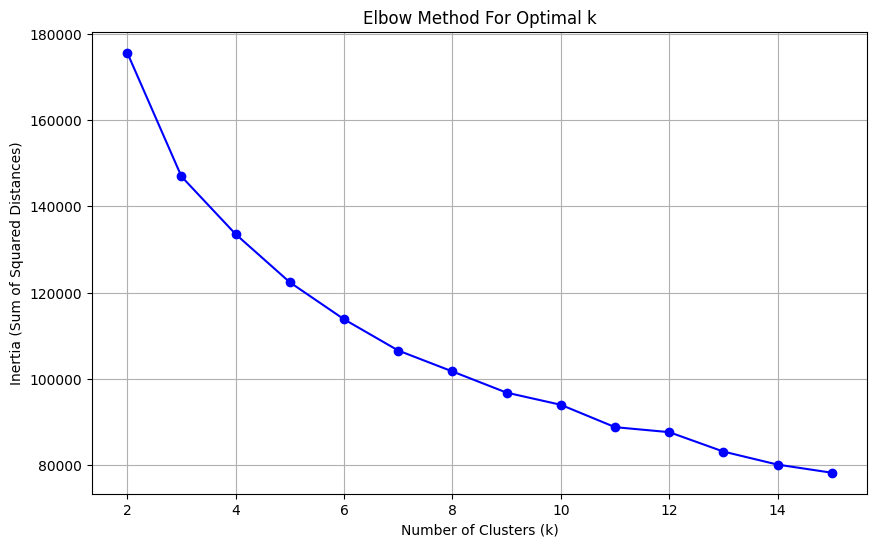

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Try different k values
results = {}
inertias = []

# Test for k from 2 to 16
k_range = range(2, 16)

for k in k_range: 
    kmeans_tmp = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    
    # Fit the model
    kmeans_tmp.fit(X_train_selected_cluster_df)
    labels_tmp = kmeans_tmp.labels_

    # Calculate Metrics (Existing code)
    sil_score = silhouette_score(X_train_selected_cluster_df, labels_tmp)
    dbi_score = davies_bouldin_score(X_train_selected_cluster_df, labels_tmp)

    # Store results (Existing code)
    results[k] = {"silhouette": sil_score, "DBI": dbi_score}
    
    # Store Inertia (NEW for Elbow Plot)
    inertias.append(kmeans_tmp.inertia_)
    
    print(f"k={k}, silhouette={sil_score:.3f}, DBI={dbi_score:.3f}, Inertia={kmeans_tmp.inertia_:.0f}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


We found that k = 2 is the best option for K-Means

In [42]:
# K-Means Clustering
from sklearn.cluster import KMeans

# Clustering on selected features
kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE)
train_clusters = kmeans.fit_predict(X_train_selected_cluster_df)
val_clusters = kmeans.predict(X_val_selected_cluster_df)

# Add cluster labels as new feature
X_train_selected_cluster_df["KMeans_Cluster"] = train_clusters
X_val_selected_cluster_df["KMeans_Cluster"] = val_clusters


#### DBSCAN:

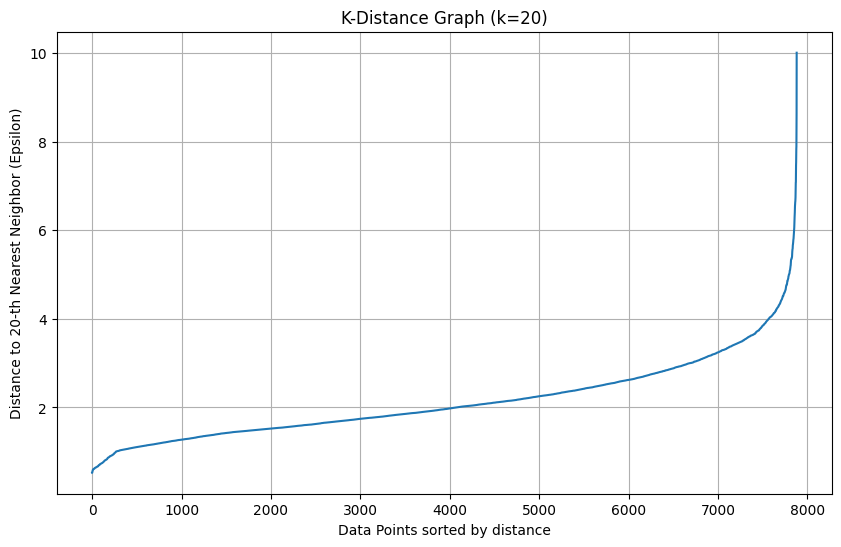

eps=0.5, min_samples=2, silhouette=-0.452, DBI=1.377
eps=0.5, min_samples=3, silhouette=-0.509, DBI=1.459
eps=0.5, min_samples=4, silhouette=-0.490, DBI=1.505
eps=0.5, min_samples=5, silhouette=-0.481, DBI=1.527
eps=0.5, min_samples=6, silhouette=-0.381, DBI=1.577
eps=0.5, min_samples=7, silhouette=-0.375, DBI=1.718
eps=0.5, min_samples=8, silhouette=-0.360, DBI=1.628
eps=0.5, min_samples=9, silhouette=-0.357, DBI=1.638
eps=0.5, min_samples=10, silhouette=-0.355, DBI=1.671
eps=1.0, min_samples=2, silhouette=-0.329, DBI=1.381
eps=1.0, min_samples=3, silhouette=-0.401, DBI=1.474
eps=1.0, min_samples=4, silhouette=-0.431, DBI=1.514
eps=1.0, min_samples=5, silhouette=-0.448, DBI=1.640
eps=1.0, min_samples=6, silhouette=-0.452, DBI=1.682
eps=1.0, min_samples=7, silhouette=-0.453, DBI=1.644
eps=1.0, min_samples=8, silhouette=-0.465, DBI=1.565
eps=1.0, min_samples=9, silhouette=-0.449, DBI=1.687
eps=1.0, min_samples=10, silhouette=-0.445, DBI=1.722
eps=1.5, min_samples=2, silhouette=-0.391, D

In [43]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Use your PCA-transformed training data
data_for_dbscan = X_train_selected_cluster_df.values 

# 2. Calculate Nearest Neighbors
# Rule of thumb: k = 2 * dimensions. You have 10 dimensions, so k=20.
k = 20 
nbrs = NearestNeighbors(n_neighbors=k).fit(data_for_dbscan)
distances, indices = nbrs.kneighbors(data_for_dbscan)

# 3. Sort and Plot K-Distance Graph
# We look at the distance to the k-th nearest neighbor
k_distances = distances[:, k-1]
k_distances = np.sort(k_distances)

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title(f'K-Distance Graph (k={k})')
plt.ylabel(f'Distance to {k}-th Nearest Neighbor (Epsilon)')
plt.xlabel('Data Points sorted by distance')
plt.grid(True)
plt.show()

eps_values = np.arange(0.5,4,0.5)    
min_samples_values = np.arange(2,11,1)            

# Loop over all combinations and just print results
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_train_selected_cluster_df)

        # Skip cases where DBSCAN assigns all points to noise (-1) or only one cluster
        if len(set(labels)) > 1 and not all(l == -1 for l in labels):
            sil_score = silhouette_score(X_train_selected_cluster_df, labels)
            dbi_score = davies_bouldin_score(X_train_selected_cluster_df, labels)

            print(f"eps={eps}, min_samples={min_samples}, "
                  f"silhouette={sil_score:.3f}, DBI={dbi_score:.3f}")


We analyzed the results and found that eps = 3.5 with min_samples = 10 provided the best clustering performance, with a silouhette score comaprable to Kmean.

In [44]:
eps, min_samples = 3.5, 10
print("Using eps =", eps, "and min_samples =", min_samples)

# Fit DBSCAN (exclude cluster labels as features)
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
train_clusters_db = dbscan.fit_predict(X_train_selected_cluster_df.drop(columns=["KMeans_Cluster"], errors="ignore"))
val_clusters_db = dbscan.fit_predict(X_val_selected_cluster_df.drop(columns=["KMeans_Cluster"], errors="ignore"))

# Add cluster labels as new feature
X_train_selected_cluster_df["DBSCAN_Cluster"] = train_clusters_db
X_val_selected_cluster_df["DBSCAN_Cluster"] = val_clusters_db

# Show cluster label counts
print('KMeans cluster counts:')
print(X_train_selected_cluster_df['KMeans_Cluster'].value_counts())
print('\nDBSCAN cluster counts (train only):')
print(X_train_selected_cluster_df['DBSCAN_Cluster'].value_counts())

Using eps = 3.5 and min_samples = 10
KMeans cluster counts:
KMeans_Cluster
0    6580
1    1302
Name: count, dtype: int64

DBSCAN cluster counts (train only):
DBSCAN_Cluster
 0    7748
-1     105
 1      29
Name: count, dtype: int64


In [45]:
from sklearn.metrics import silhouette_score

# Prepare features (exclude cluster label columns)
feature_cols_for_sil = X_train_selected_cluster_df.columns.difference(
    ["KMeans_Cluster", "DBSCAN_Cluster"]
)
X_train_features_only = X_train_selected_cluster_df[feature_cols_for_sil]

# KMeans silhouette 
kmeans_silhouette = silhouette_score(X_train_features_only, train_clusters)
kmeans_dbi = davies_bouldin_score(X_train_features_only, train_clusters)

# DBSCAN silhouette (ignore noise points)
dbscan_mask = train_clusters_db != -1
if dbscan_mask.sum() > 1 and len(set(train_clusters_db[dbscan_mask])) > 1:
    dbscan_silhouette = silhouette_score(
        X_train_features_only[dbscan_mask], train_clusters_db[dbscan_mask]
    )
    dbscan_dbi = davies_bouldin_score(
        X_train_features_only[dbscan_mask], train_clusters_db[dbscan_mask]
    )
else:
    dbscan_silhouette = None
    dbscan_dbi = None

# Compare results
print("Silhouette Score and Davies-Bouldin Index Comparison")
print("---------------------------")
print(f"KMeans: {kmeans_silhouette:.3f}")
print(f"DBI KMeans: {kmeans_dbi:.3f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN: {dbscan_silhouette:.3f}")
    print(f"DBI DBSCAN: {dbscan_dbi:.3f}")
else:
    print("DBSCAN: Not enough clusters formed (all noise or single cluster)")


Silhouette Score and Davies-Bouldin Index Comparison
---------------------------
KMeans: 0.450
DBI KMeans: 1.000
DBSCAN: 0.655
DBI DBSCAN: 0.351


We choose DBSCAN Clustering because it has better performance

### Retrain new model with cluster label:

In [46]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)


X_train_union.loc[:, "DBSCAN_Cluster"] = train_clusters_db
X_val_union.loc[:, "DBSCAN_Cluster"] = val_clusters_db

# Using SMOTE to fix data imbalance before training
X_train_for_model = X_train_union.copy()
X_val_for_model = X_val_union.copy()

X_train_smote_cluster, y_train_smote_cluster = smote.fit_resample(X_train_for_model, y_train)

In [47]:
# Logistic Regression with hyperparameter tuning
params_log = {
    'C': [0.001, 0.01, 0.1, 1, 5],
    'solver': ['lbfgs'],
    'max_iter': [100,200,500]
}
skf = StratifiedKFold(n_splits = 10,random_state=RANDOM_STATE, shuffle=True)
LR_hyper = GridSearchCV(LR, param_grid = params_log, n_jobs =-1, cv = skf)
model_LogR_hyper_cluster, results_class = train_and_save_hyper(LR_hyper, X_train_smote_cluster, y_train_smote_cluster, X_val_for_model, y_val, "Logistic Regression Cluster", results_class)

Model accuracy for train set: 0.851
Model accuracy for test set: 0.874
Best parameters found:  {'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}
Best cross-validation score:  0.8513919221787922

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1416
           1       0.58      0.78      0.67       273

    accuracy                           0.87      1689
   macro avg       0.77      0.84      0.79      1689
weighted avg       0.89      0.87      0.88      1689


Confusion Matrix:
 [[1263  153]
 [  60  213]]

Accuracy Score:  0.874


In [48]:
# Random Forest with hyperparameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold

params_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [4, 7, 10],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'class_weight': ['balanced']
}

# Hyperparameter tunning using GridSearchCV
skf = StratifiedKFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
RF_hyper = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), param_grid=params_rf, n_jobs=-1, cv=skf)
model_RF_hyper_cluster, results_class = train_and_save_hyper(
    RF_hyper, X_train_smote_cluster, y_train_smote_cluster, X_val_for_model, y_val, "Random Forest Cluster ", results_class
)

d:\project\bs_re\rmit_pds_asm3\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model accuracy for train set: 0.967
Model accuracy for test set: 0.890
Best parameters found:  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 500}
Best cross-validation score:  0.9300853431304621

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1416
           1       0.63      0.78      0.70       273

    accuracy                           0.89      1689
   macro avg       0.79      0.85      0.82      1689
weighted avg       0.90      0.89      0.90      1689


Confusion Matrix:
 [[1290  126]
 [  59  214]]

Accuracy Score:  0.89


In [49]:
from sklearn.ensemble import VotingClassifier
hybrid_model_cluster = VotingClassifier(
    estimators=[('lr', model_LogR_hyper_cluster.best_estimator_), ('rf', model_RF_hyper_cluster.best_estimator_)],
    voting='soft',
    weights=[1,2]
)

hybrid_model_cluster, results_class = train_and_save(
    hybrid_model_cluster, X_train_smote_cluster, y_train_smote_cluster, X_val_for_model, y_val, "Ensemble Model LR-RF Cluster", results_class
)

Model accuracy for train set: 0.945
Model accuracy for test set: 0.881

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1416
           1       0.60      0.79      0.68       273

    accuracy                           0.88      1689
   macro avg       0.78      0.84      0.80      1689
weighted avg       0.90      0.88      0.89      1689


Confusion Matrix:
 [[1272  144]
 [  57  216]]

Accuracy Score:  0.881


#### Model performance comparison:

<Figure size 2000x1000 with 0 Axes>

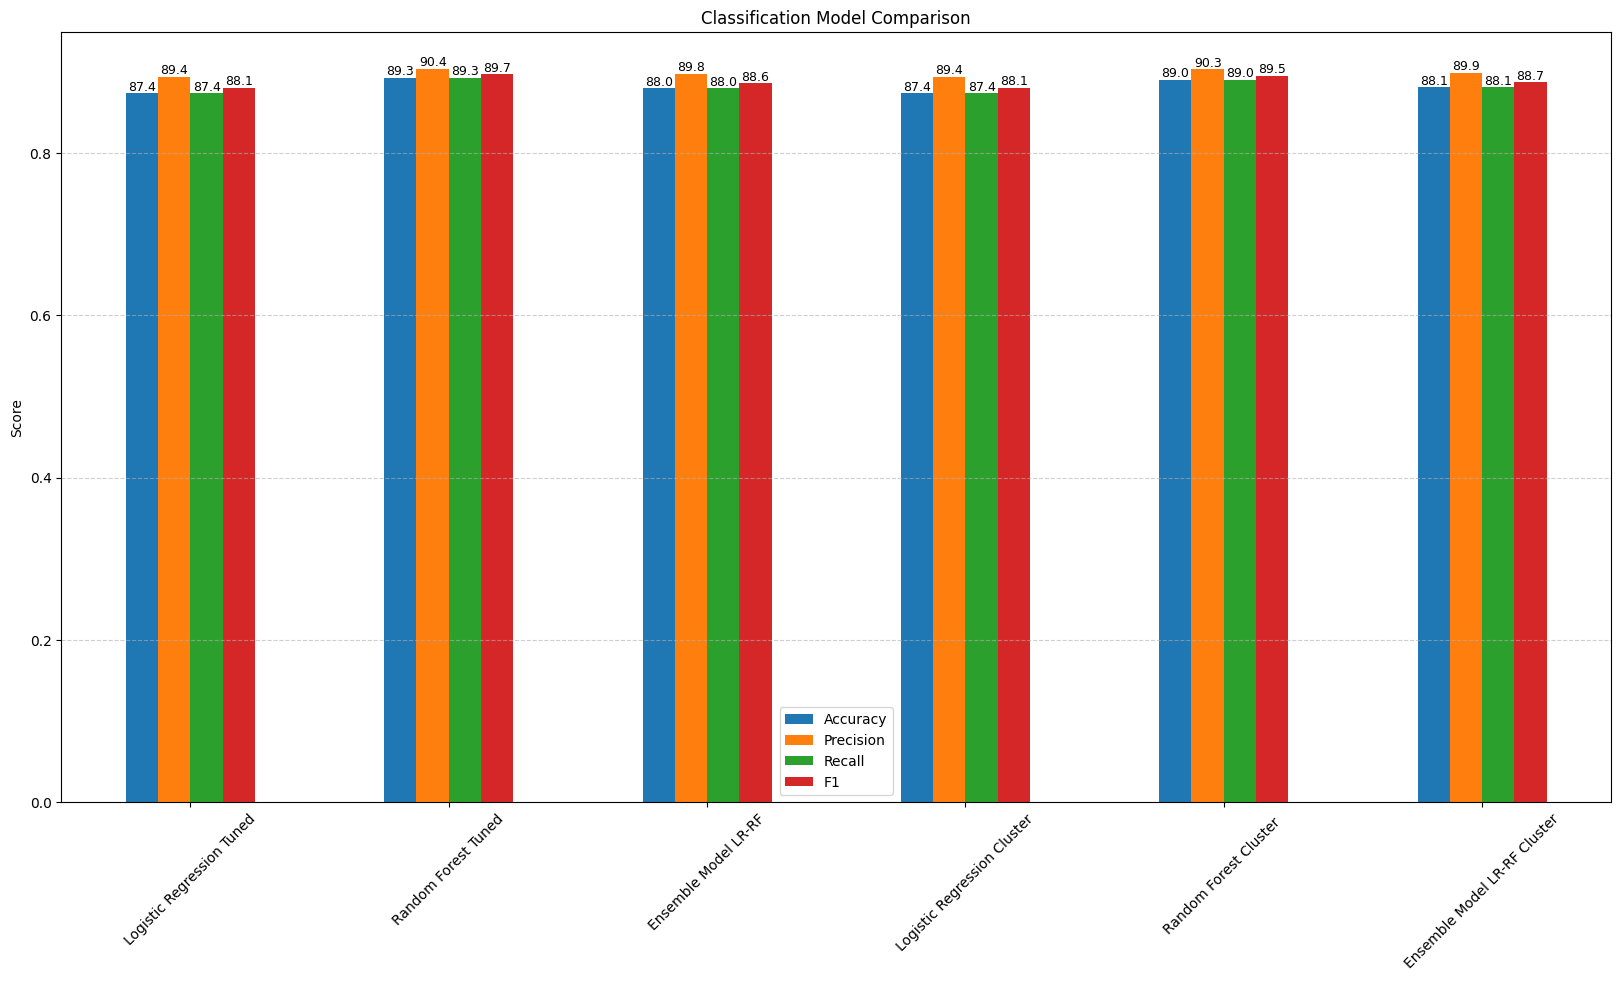

In [50]:
results_class_df = pd.DataFrame(results_class).T

plot_classification_results(results_class_df)

The best model choice will be Random Forest

## Reference:

- Cory Maklin. (n.d.). Synthetic Minority Over-sampling TEchnique (SMOTE). Retrieved January 15, 2026, from https://medium.com/@corymaklin/synthetic-minority-over-sampling-technique-smote-7d419696b88c  
- GeeksforGeeks. (2025a, July 11). Silhouette Algorithm to determine the optimal value of k. GeeksforGeeks. Retrieved January 15, 2026, from https://www.geeksforgeeks.org/machine-learning/silhouette-algorithm-to-determine-the-optimal-value-of-k/  
- GeeksforGeeks. (2025b, July 23). DaviesBouldin Index. GeeksforGeeks. Retrieved January 15, 2026, from https://www.geeksforgeeks.org/machine-learning/davies-bouldin-index/  
- GeeksforGeeks. (2025c, July 23). Recursive Feature Elimination with CrossValidation in Scikit Learn. GeeksforGeeks. Retrieved January 15, 2026, from https://www.geeksforgeeks.org/machine-learning/recursive-feature-elimination-with-cross-validation-in-scikit-learn/  
- LogisticRegression. (n.d.). Scikit-learn. Retrieved January 15, 2026, from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
- RandomForestClassifier. (n.d.). Scikit-learn. Retrieved January 15, 2026, from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
- UCI Machine Learning Repository. (n.d.). Retrieved January 15, 2026, from https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset